In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("benjaminawd/new-york-times-articles-comments-2020")

print("Path to dataset files:", path)

Mounting files to /kaggle/input/new-york-times-articles-comments-2020...
Path to dataset files: /kaggle/input/new-york-times-articles-comments-2020


In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Step 1: Load only a small sample
comments = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-comments-2020.csv", nrows=50000)  # Just 50K rows
articles = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv")

# Step 2: Merge on articleID
df = comments.merge(articles, left_on="articleID", right_on="uniqueID", how="left")

# Step 3: Drop rows with missing comment or target
df = df.dropna(subset=["commentBody", "editorsSelection"])
df['editorsSelection'] = df['editorsSelection'].astype(bool).astype(int)

# Step 4: Balance the dataset (Times Picks are rare)
picks = df[df['editorsSelection'] == 1]
non_picks = df[df['editorsSelection'] == 0].sample(n=len(picks)*3, random_state=42)
df_balanced = pd.concat([picks, non_picks])

# Step 5: Select features
text_col = 'commentBody'
cat_cols = ['newsdesk', 'section', 'material']
num_cols = ['recommendations', 'replyCount', 'word_count', 'n_comments']

# Fill missing values
df_balanced[cat_cols] = df_balanced[cat_cols].fillna("unknown")
df_balanced[num_cols] = df_balanced[num_cols].fillna(0)

# Step 6: Train-test split
X = df_balanced[[text_col] + cat_cols + num_cols]
y = df_balanced['editorsSelection']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 7: Build pipeline
preprocessor = ColumnTransformer([
    ('text', TfidfVectorizer(max_features=10000, stop_words='english'), text_col),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

# Step 8: Train and evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))


/tmp/ipykernel_31/4224616927.py:11: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  comments = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-comments-2020.csv", nrows=50000)  # Just 50K rows


              precision    recall  f1-score   support

           0       0.94      0.95      0.95       366
           1       0.85      0.82      0.84       122

    accuracy                           0.92       488
   macro avg       0.90      0.89      0.89       488
weighted avg       0.92      0.92      0.92       488



In [2]:
!pip install transformers sentence-transformers -q



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [60]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load small, fast BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # ~384-dim output

# Encode all comment bodies
comment_embeddings = model.encode(df_balanced['commentBody'].tolist(), show_progress_bar=True)


Batches:   0%|          | 0/77 [00:00<?, ?it/s]

In [61]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Preprocess non-text features
cat_cols = ['newsdesk', 'section', 'material']
num_cols = ['recommendations', 'replyCount', 'word_count', 'n_comments']

# Fill missing
df_balanced[cat_cols] = df_balanced[cat_cols].fillna("unknown")
df_balanced[num_cols] = df_balanced[num_cols].fillna(0)

# One-hot encode categorical
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_cat = encoder.fit_transform(df_balanced[cat_cols])

# Standardize numerical
scaler = StandardScaler()
X_num = scaler.fit_transform(df_balanced[num_cols])

# Final input matrix
import numpy as np
X_final = np.hstack([comment_embeddings, X_cat, X_num])
y_final = df_balanced['editorsSelection'].values


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, stratify=y_final, test_size=0.2, random_state=42)

model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.94      0.95       366
           1       0.83      0.87      0.85       122

    accuracy                           0.92       488
   macro avg       0.90      0.91      0.90       488
weighted avg       0.93      0.92      0.92       488



In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Step 1: Load only a small sample
comments = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-comments-2020.csv", nrows=50000)  # Just 50K rows
articles = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv")

# Step 2: Merge on articleID
df = comments.merge(articles, left_on="articleID", right_on="uniqueID", how="left")

# Step 3: Drop rows with missing comment or target
df = df.dropna(subset=["commentBody", "editorsSelection"])
df['editorsSelection'] = df['editorsSelection'].astype(bool).astype(int)

# Step 4: Balance the dataset (Times Picks are rare)
picks = df[df['editorsSelection'] == 1]
non_picks = df[df['editorsSelection'] == 0].sample(n=len(picks)*3, random_state=42)
df_balanced = pd.concat([picks, non_picks])

# Step 5: Select features
text_col = 'commentBody'
cat_cols = ['newsdesk', 'section', 'material']
num_cols = ['recommendations', 'replyCount', 'word_count', 'n_comments']
# Fill missing values
df_balanced[cat_cols] = df_balanced[cat_cols].fillna("unknown")
df_balanced[num_cols] = df_balanced[num_cols].fillna(0)


/tmp/ipykernel_31/806802643.py:11: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  comments = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-comments-2020.csv", nrows=50000)  # Just 50K rows


In [5]:
from sentence_transformers import SentenceTransformer

# Load BERT encoder again (in case it's overwritten)
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Combine commentBody + headline + abstract
df_balanced['combined_text'] = (
    df_balanced['commentBody'].fillna('') + ' ' +
    df_balanced['headline'].fillna('') + ' ' +
    df_balanced['abstract'].fillna('')
)

# Encode with BERT
text_embeddings = bert_model.encode(df_balanced['combined_text'].tolist(), show_progress_bar=True)
from sklearn.linear_model import LogisticRegression




Batches:   0%|          | 0/77 [00:00<?, ?it/s]

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    text_embeddings, df_balanced['editorsSelection'].values,
    stratify=df_balanced['editorsSelection'],
    test_size=0.2, random_state=42
)

clf = LogisticRegression(class_weight='balanced', max_iter=1000)
clf.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [7]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      0.65      0.73       366
           1       0.37      0.62      0.47       122

    accuracy                           0.64       488
   macro avg       0.61      0.64      0.60       488
weighted avg       0.72      0.64      0.67       488



In [14]:
!pip install xgboost -q


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [69]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),  # handle imbalance
    random_state=42
)

xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)


In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.95      0.95       366
           1       0.86      0.88      0.87       122

    accuracy                           0.93       488
   macro avg       0.91      0.91      0.91       488
weighted avg       0.93      0.93      0.93       488



In [71]:
import joblib

joblib.dump(xgb_clf, '/kaggle/working/xgb_bert_meta_model.pkl')
joblib.dump(encoder, '/kaggle/working/onehot_encoder.pkl')
joblib.dump(scaler, '/kaggle/working/num_scaler.pkl')


['/kaggle/working/num_scaler.pkl']

In [72]:
import pandas as pd
import numpy as np
import joblib
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Load trained model and preprocessors
xgb_clf = joblib.load('/kaggle/working/xgb_bert_meta_model.pkl')
encoder = joblib.load('/kaggle/working/onehot_encoder.pkl')
scaler = joblib.load('/kaggle/working/num_scaler.pkl')
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Load data
comments = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-comments-2020.csv")
articles = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv")

# Merge and keep labeled rows
df = comments.merge(articles, left_on="articleID", right_on="uniqueID", how="left")
df_labeled = df[df['editorsSelection'].notnull()].copy()
df_labeled['target'] = df_labeled['editorsSelection'].astype(int)

# Optionally balance or stratify, but here we just split
from sklearn.model_selection import train_test_split
_, eval_df = train_test_split(df_labeled, test_size=0.2, random_state=42, stratify=df_labeled['target'])

# Text embeddings
X_text = bert_model.encode(eval_df['commentBody'].fillna('').tolist(), show_progress_bar=True)

# Metadata preprocessing
cat_cols = ['newsdesk', 'section', 'material']
num_cols = ['recommendations', 'replyCount', 'word_count', 'n_comments']
eval_df[cat_cols] = eval_df[cat_cols].fillna("unknown")
eval_df[num_cols] = eval_df[num_cols].fillna(0)

X_cat = encoder.transform(eval_df[cat_cols])
X_num = scaler.transform(eval_df[num_cols])

# Final feature matrix
X_eval = np.hstack([X_text, X_cat, X_num])
y_eval = eval_df['target'].values

# Predict and evaluate
y_pred = xgb_clf.predict(X_eval)
print("✅ Evaluation on BERT + metadata model:\n")
print(classification_report(y_eval, y_pred, digits=4))
print("🎯 Accuracy:", round(accuracy_score(y_eval, y_pred), 4))


/tmp/ipykernel_31/3476430578.py:15: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  comments = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-comments-2020.csv")


Batches:   0%|          | 0/31166 [00:00<?, ?it/s]

✅ Evaluation on BERT + metadata model:

              precision    recall  f1-score   support

           0     0.9983    0.9488    0.9729    985887
           1     0.1627    0.8591    0.2736     11406

    accuracy                         0.9478    997293
   macro avg     0.5805    0.9040    0.6233    997293
weighted avg     0.9887    0.9478    0.9649    997293

🎯 Accuracy: 0.9478


In [65]:
# Save the model and vectorizer
joblib.dump(xgb_clf, 'xgb_timespick_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [66]:
i m doing thi 
import pandas as pd
import joblib
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Load model and vectorizer
xgb_clf = joblib.load('/kaggle/working/xgb_timespick_model.pkl')
tfidf_vectorizer = joblib.load('/kaggle/working/tfidf_vectorizer.pkl')

# Load full NYT datasets
comments = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-comments-2020.csv")
articles = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv")

# Merge datasets
df = comments.merge(articles, left_on="articleID", right_on="uniqueID", how="left")

# Keep only labeled rows
df_labeled = df[df['editorsSelection'].notnull()].copy()
df_labeled['target'] = df_labeled['editorsSelection'].astype(int)

# Held-out evaluation split (20% of labeled data)
_, eval_df = train_test_split(
    df_labeled, test_size=0.2, random_state=42, stratify=df_labeled['target']
)

# Prepare evaluation data
X_eval_text = eval_df['commentBody'].fillna('')
y_eval = eval_df['target']

# Vectorize and predict
X_eval_vec = tfidf_vectorizer.transform(X_eval_text)
y_pred = xgb_clf.predict(X_eval_vec)

# Show results
print("✅ Evaluation on held-out labeled Times Pick data:\n")
print(classification_report(y_eval, y_pred, digits=4))
print("🎯 Accuracy:", round(accuracy_score(y_eval, y_pred), 4))

/tmp/ipykernel_31/3577793238.py:11: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  comments = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-comments-2020.csv")


KeyboardInterrupt: 

✅ Evaluation on held-out labeled Times Pick data:

              precision    recall  f1-score   support

           0     0.9889    0.9780    0.9834    985887
           1     0.0257    0.0502    0.0340     11406

    accuracy                         0.9674    997293
   macro avg     0.5073    0.5141    0.5087    997293
weighted avg     0.9779    0.9674    0.9726    997293

🎯 Accuracy: 0.9674

In [49]:
print(test_df.columns.tolist())


['newsdesk', 'section', 'subsection', 'material', 'headline', 'abstract', 'keywords', 'word_count', 'pub_date', 'is_popular', 'uniqueID']


In [32]:
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

NameError: name 'tfidf_vectorizer' is not defined

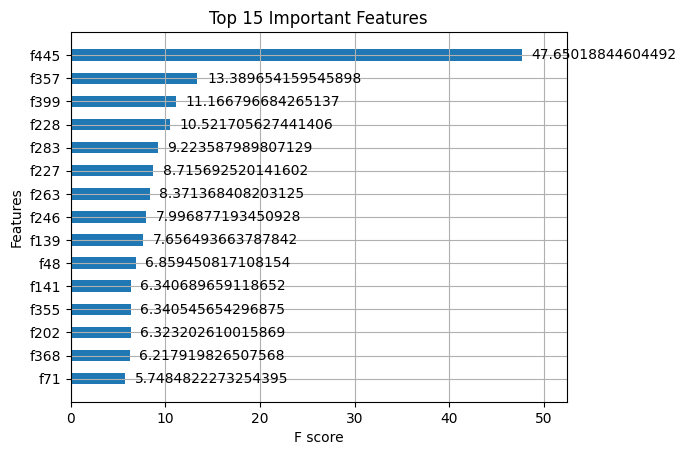

In [17]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(xgb_clf, max_num_features=15, height=0.5, importance_type='gain')
plt.title("Top 15 Important Features")
plt.show()


In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import numpy as np

# Prepare metadata
df_meta = df_balanced[['section', 'material', 'word_count']].copy()
df_meta['section'] = df_meta['section'].fillna('unknown')
df_meta['material'] = df_meta['material'].fillna('unknown')

# One-hot encode section & material
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
meta_encoded = ohe.fit_transform(df_meta[['section', 'material']])

# Combine BERT + metadata
X_combined = np.hstack([text_embeddings, meta_encoded, df_meta[['word_count']].values])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, df_balanced['editorsSelection'], test_size=0.2, stratify=df_balanced['editorsSelection'], random_state=42
)

# Train XGBoost
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    random_state=42
)
xgb_clf.fit(X_train, y_train)

# Evaluate
y_pred = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.78      0.93      0.85       366
           1       0.53      0.23      0.32       122

    accuracy                           0.76       488
   macro avg       0.66      0.58      0.59       488
weighted avg       0.72      0.76      0.72       488



In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Use only comment text
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['commentBody'], df['times_pick'], test_size=0.2, random_state=42, stratify=df['times_pick'])

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english')
X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=2)
xgb.fit(X_train, y_train)

# Evaluate
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))


KeyError: 'times_pick'

In [22]:
print(df.columns.tolist())



['commentID', 'status', 'commentSequence', 'userID', 'userDisplayName', 'userLocation', 'userTitle', 'commentBody', 'createDate', 'updateDate', 'approveDate', 'recommendations', 'replyCount', 'editorsSelection', 'parentID', 'parentUserDisplayName', 'depth', 'commentType', 'trusted', 'recommendedFlag', 'permID', 'isAnonymous', 'articleID', 'newsdesk', 'section', 'subsection', 'material', 'headline', 'abstract', 'keywords', 'word_count', 'pub_date', 'n_comments', 'uniqueID']


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Split dataset
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['commentBody'], df['editorsSelection'], test_size=0.2, random_state=42, stratify=df['editorsSelection'])

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# Train XGBoost
# Calculate class weight manually
scale_weight = (len(y_train) - sum(y_train)) / sum(y_train)

xgb_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_weight
)
xgb_clf.fit(X_train, y_train)

# Predict + Report
y_pred = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.97      0.98      9878
           1       0.03      0.08      0.04       122

    accuracy                           0.96     10000
   macro avg       0.51      0.52      0.51     10000
weighted avg       0.98      0.96      0.97     10000



In [28]:
import pandas as pd

# Load your test CSV
test_df = pd.read_csv('/kaggle/input/new-york-times-articles-comments-2020/test.csv')  # update path if needed


In [31]:
import joblib

# Load the model and vectorizer
xgb_clf = joblib.load('/kaggle/working/xgb_timespick_model.pkl')
tfidf_vectorizer = joblib.load('/kaggle/input/your-model-folder/tfidf_vectorizer.pkl')


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/your-model-folder/tfidf_vectorizer.pkl'

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Recreate vectorizer from training text
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vec = tfidf_vectorizer.fit_transform(X_train_text)  # or use df['commentBody'] if needed


In [34]:
import joblib

# Save model and vectorizer
joblib.dump(xgb_clf, 'xgb_timespick_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [37]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import joblib
from xgboost import XGBClassifier

# Load your dataset
# Step 1: Load only a small sample
comments = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-comments-2020.csv", nrows=50000)  # Just 50K rows
articles = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv")

# Step 2: Merge on articleID
df = comments.merge(articles, left_on="articleID", right_on="uniqueID", how="left")

# Prepare data
df['target'] = df['editorsSelection'].astype(int)  # 1 for Times Pick, 0 otherwise
X = df['commentBody'].fillna('')
y = df['target']

# Train-test split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vec = tfidf_vectorizer.fit_transform(X_train_text)
X_test_vec = tfidf_vectorizer.transform(X_test_text)

# XGBoost Classifier
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    random_state=42
)

# Train the model
xgb_clf.fit(X_train_vec, y_train)

# Save the model and vectorizer
joblib.dump(xgb_clf, 'xgb_timespick_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

print("✅ Model and vectorizer saved successfully.")


/tmp/ipykernel_31/2733770700.py:9: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  comments = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-comments-2020.csv", nrows=50000)  # Just 50K rows


✅ Model and vectorizer saved successfully.


In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      9878
           1       0.03      0.08      0.04       122

    accuracy                           0.96     10000
   macro avg       0.51      0.52      0.51     10000
weighted avg       0.98      0.96      0.97     10000



In [57]:
# Step 1: Load only a small sample
comments = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-comments-2020.csv", nrows=50000)  # Just 50K rows
articles = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv")

# Step 2: Merge on articleID
df = comments.merge(articles, left_on="articleID", right_on="uniqueID", how="left")


# Re-train using 50k labeled samples
df = df[df['editorsSelection'].notnull()]
df['target'] = df['editorsSelection'].astype(int)

X = df['commentBody'].fillna('')
y = df['target']

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
import joblib

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vec = tfidf_vectorizer.fit_transform(X_train)
X_test_vec = tfidf_vectorizer.transform(X_test)

# Model
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    random_state=42
)
xgb_clf.fit(X_train_vec, y_train)

# Save both
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(xgb_clf, 'xgb_timespick_model.pkl')


/tmp/ipykernel_31/249632966.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  comments = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-comments-2020.csv", nrows=50000)  # Just 50K rows


KeyboardInterrupt: 

In [ ]:
print(classification_report(y_test, y_pred))

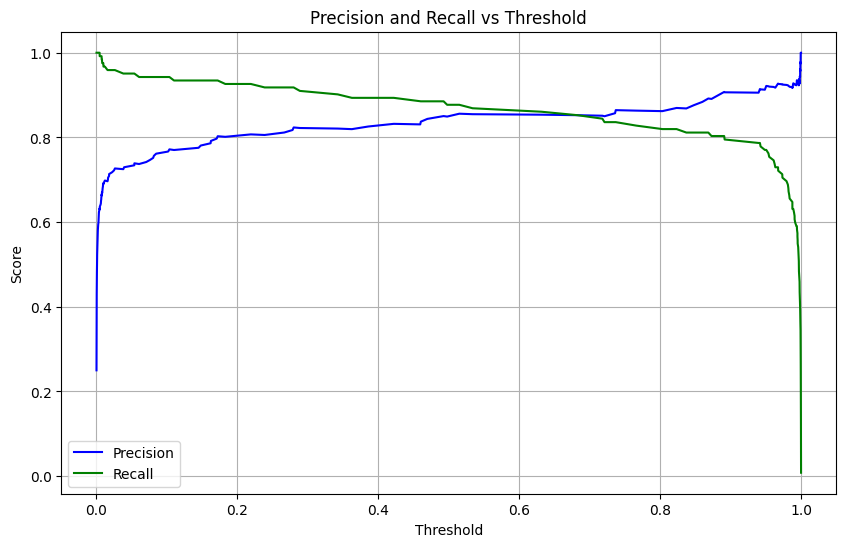

In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report

# Get predicted probabilities for class 1
y_probs = xgb_clf.predict_proba(X_test)[:, 1]

# Compute precision-recall-threshold curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Plot precision and recall vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label="Precision", color="b")
plt.plot(thresholds, recalls[:-1], label="Recall", color="g")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()


In [74]:
# Try a few custom thresholds after inspecting the curve
for thresh in [0.6, 0.7, 0.8, 0.9]:
    y_pred_thresh = (y_probs > thresh).astype(int)
    print(f"\n🔎 Threshold = {thresh}")
    print(classification_report(y_test, y_pred_thresh, digits=4))



🔎 Threshold = 0.6
              precision    recall  f1-score   support

           0     0.9534    0.9508    0.9521       366
           1     0.8537    0.8607    0.8571       122

    accuracy                         0.9283       488
   macro avg     0.9035    0.9057    0.9046       488
weighted avg     0.9285    0.9283    0.9284       488


🔎 Threshold = 0.7
              precision    recall  f1-score   support

           0     0.9482    0.9508    0.9495       366
           1     0.8512    0.8443    0.8477       122

    accuracy                         0.9242       488
   macro avg     0.8997    0.8975    0.8986       488
weighted avg     0.9240    0.9242    0.9241       488


🔎 Threshold = 0.8
              precision    recall  f1-score   support

           0     0.9409    0.9563    0.9485       366
           1     0.8621    0.8197    0.8403       122

    accuracy                         0.9221       488
   macro avg     0.9015    0.8880    0.8944       488
weighted avg     

In [75]:
# Set optimal threshold for future predictions
optimal_thresh = 0.9
final_preds = (y_probs > optimal_thresh).astype(int)

# Optional: Save model and threshold
import joblib
joblib.dump((xgb_clf, optimal_thresh), "/kaggle/working/final_bert_meta_model_with_thresh.pkl")


['/kaggle/working/final_bert_meta_model_with_thresh.pkl']

In [76]:
import joblib

# Load model and threshold
xgb_clf, optimal_thresh = joblib.load("/kaggle/working/final_bert_meta_model_with_thresh.pkl")


In [5]:
import kagglehub

# Download latest version
path = kagglehub.model_download("luvagarwal23110189/op/other/default")

print("Path to model files:", path)

Path to model files: /kaggle/input/op/other/default/1


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load NYT data
comments = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-comments-2020.csv")
articles = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv")

# Merge comments and articles
df = comments.merge(articles, left_on="articleID", right_on="uniqueID", how="left")

# Only labeled comments
df_labeled = df[df['editorsSelection'].notnull()].copy()
df_labeled['editorsSelection'] = df_labeled['editorsSelection'].astype(int)

# Split into evaluation (20%)
_, df_eval = train_test_split(df_labeled, test_size=0.2, random_state=42, stratify=df_labeled['editorsSelection'])


/tmp/ipykernel_31/1506869829.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  comments = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-comments-2020.csv")


In [10]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import joblib

# Load model and threshold
xgb_clf, optimal_thresh = joblib.load("/kaggle/input/op/other/default/1/final_bert_meta_model_with_thresh.pkl")

# Load encoder and scaler (saved during training)
encoder = joblib.load("/kaggle/input/op/other/default/1/onehot_encoder.pkl")
scaler = joblib.load("/kaggle/input/op/other/default/1/num_scaler.pkl")

# Load BERT
model = SentenceTransformer('all-MiniLM-L6-v2')

# Embed comments
comment_embeddings = model.encode(df_eval['commentBody'].fillna('').tolist(), show_progress_bar=True)

# Preprocess metadata
cat_cols = ['newsdesk', 'section', 'material']
num_cols = ['recommendations', 'replyCount', 'word_count', 'n_comments']

df_eval[cat_cols] = df_eval[cat_cols].fillna("unknown")
df_eval[num_cols] = df_eval[num_cols].fillna(0)

X_cat = encoder.transform(df_eval[cat_cols])
X_num = scaler.transform(df_eval[num_cols])

# Final input matrix
X_eval_final = np.hstack([comment_embeddings, X_cat, X_num])
y_eval = df_eval['editorsSelection'].values

# Predict with threshold
y_probs = xgb_clf.predict_proba(X_eval_final)[:, 1]
y_pred_thresh = (y_probs > optimal_thresh).astype(int)

# Evaluate
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_eval, y_pred_thresh, digits=4))
print("🎯 Accuracy:", round(accuracy_score(y_eval, y_pred_thresh), 4))


Batches:   0%|          | 0/31166 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.9971    0.9751    0.9860    985887
           1     0.2590    0.7523    0.3853     11406

    accuracy                         0.9725    997293
   macro avg     0.6280    0.8637    0.6856    997293
weighted avg     0.9886    0.9725    0.9791    997293

🎯 Accuracy: 0.9725


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load NYT data
comments = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-comments-2020.csv")
articles = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv")

# Merge comments and articles
df = comments.merge(articles, left_on="articleID", right_on="uniqueID", how="left")

# Only labeled comments
df_labeled = df[df['editorsSelection'].notnull()].copy()
df_labeled['editorsSelection'] = df_labeled['editorsSelection'].astype(int)

# Split into evaluation (20%)
df_eval = df_labeled


/tmp/ipykernel_31/4192715822.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  comments = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-comments-2020.csv")


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import joblib

# Load model and threshold
xgb_clf, optimal_thresh = joblib.load("/kaggle/input/op/other/default/1/final_bert_meta_model_with_thresh.pkl")

# Load encoder and scaler (saved during training)
encoder = joblib.load("/kaggle/input/op/other/default/1/onehot_encoder.pkl")
scaler = joblib.load("/kaggle/input/op/other/default/1/num_scaler.pkl")

# Load BERT
model = SentenceTransformer('all-MiniLM-L6-v2')

# Embed comments
comment_embeddings = model.encode(df_eval['commentBody'].fillna('').tolist(), show_progress_bar=True)

# Preprocess metadata
cat_cols = ['newsdesk', 'section', 'material']
num_cols = ['recommendations', 'replyCount', 'word_count', 'n_comments']

df_eval[cat_cols] = df_eval[cat_cols].fillna("unknown")
df_eval[num_cols] = df_eval[num_cols].fillna(0)

X_cat = encoder.transform(df_eval[cat_cols])
X_num = scaler.transform(df_eval[num_cols])

# Final input matrix
X_eval_final = np.hstack([comment_embeddings, X_cat, X_num])
y_eval = df_eval['editorsSelection'].values

# Predict with threshold
y_probs = xgb_clf.predict_proba(X_eval_final)[:, 1]
y_pred_thresh = (y_probs > optimal_thresh).astype(int)

# Evaluate
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_eval, y_pred_thresh, digits=4))
print("🎯 Accuracy:", round(accuracy_score(y_eval, y_pred_thresh), 4))


In [ ]:
import pandas as pd
import numpy as np
import joblib
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Load trained model and preprocessors
xgb_clf = joblib.load('/kaggle/working/xgb_bert_meta_model.pkl')
encoder = joblib.load('/kaggle/working/onehot_encoder.pkl')
scaler = joblib.load('/kaggle/working/num_scaler.pkl')
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Load data
comments = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-comments-2020.csv")
articles = pd.read_csv("/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv")

# Merge and keep labeled rows
df = comments.merge(articles, left_on="articleID", right_on="uniqueID", how="left")
df_labeled = df[df['editorsSelection'].notnull()].copy()
df_labeled['target'] = df_labeled['editorsSelection'].astype(int)

# Optionally balance or stratify, but here we just split
from sklearn.model_selection import train_test_split
_, eval_df = train_test_split(df_labeled, test_size=0.2, random_state=42, stratify=df_labeled['target'])

# Text embeddings
X_text = bert_model.encode(eval_df['commentBody'].fillna('').tolist(), show_progress_bar=True)

# Metadata preprocessing
cat_cols = ['newsdesk', 'section', 'material']
num_cols = ['recommendations', 'replyCount', 'word_count', 'n_comments']
eval_df[cat_cols] = eval_df[cat_cols].fillna("unknown")
eval_df[num_cols] = eval_df[num_cols].fillna(0)

X_cat = encoder.transform(eval_df[cat_cols])
X_num = scaler.transform(eval_df[num_cols])

# Final feature matrix
X_eval = np.hstack([X_text, X_cat, X_num])
y_eval = eval_df['target'].values

# Predict and evaluate
y_pred = xgb_clf.predict(X_eval)
print("✅ Evaluation on BERT + metadata model:\n")
print(classification_report(y_eval, y_pred, digits=4))
print("🎯 Accuracy:", round(accuracy_score(y_eval, y_pred), 4))
